In [1]:
# default_exp data.load_pd

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *

In [4]:
# hide
from nbdev.showdoc import *

# Data Load Dataframe


> Using the fastai2 `Datasets` to make an time series dataset.

A multivaraite time-series dataloader. 

TODO reduce mem: https://forums.fast.ai/t/how-to-handle-dataframes-too-large-to-fit-in-memory/39208/19

In [5]:
# export
import numpy as np
import pandas as pd

In [6]:
class TSeries(TensorBase):pass

In [7]:
def no_emp_dim(x):
    if len(x.shape)==1 :
        x = x[None,:]
    return np.vstack(x)

def show_graph(array, ax=None, figsize=None, title=None, ctx=None, tx=None, **kwargs):
    "Show an array on `ax`."
    if hasattrs(array, ('data','cpu','permute')):
        array = array.data.cpu()
    elif not isinstance(array,np.ndarray):
        array=array(array)
    arrays = no_emp_dim(array)
    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (5,5)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    tx = ifnone(tx,np.arange(arrays[0].shape[0]))
    label = kwargs.pop('label', 'x')
    for a, c in zip(arrays, ['b', 'c', 'm', 'y', 'k',]):
        ax.plot(tx, a, '-*'+c,label=label, **kwargs)

    if title is not None: ax.set_title(title)

    ax.legend()
#     ax.axis('off')
    return ax

In [8]:
# export
class TensorSeqs(TSeries):
    
    def show(self, ax = None, ctx=None, **kwargs):
        ctx = ifnone(ctx, ax)
        if ctx is None: _, ctx = plt.subplots(figsize=(5,5))
        array = np.array(self.cpu())
        arrays = no_emp_dim(array)
        m = self._meta.get('m',['b', 'c', 'm', 'y', 'k',][:len(arrays)])
        labels = self._meta.get('label',['x']*len(arrays))
        t = np.arange(array.shape[1])
        
        for a, c, label in zip(arrays, m, labels):            
            mark = '-' if 'y' not in label else ''                
            ctx.plot(t, a, mark + '*' +c, **kwargs, label=label)            #
        ctx.legend()
        return ctx
    

In [9]:
a = torch.cat([i+torch.arange(10)[None,:] for i in [0,2]])

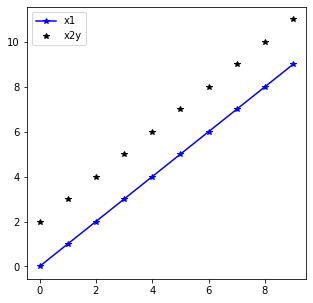

In [10]:
_, ctx = plt.subplots(figsize=[5,5])
ax = TensorSeqs(a, m=['b','k'], label = ['x1','x2y']).show(ctx=ctx)

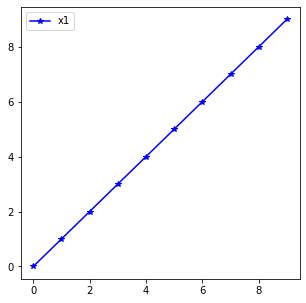

In [11]:
ax = TensorSeqs(torch.arange(10)[None,:], m=['b','k'], label = ['x1','x2']).show()

In [153]:
# export
class TensorCon(TSeries):
    def show(self, ax = None, ctx=None):
        ax = ifnone(ax,ctx)
        if ax is None:
            _, ax = plt.subplots(figsize=(5,5))
        ax.set_title(ax.title._text +f" {self._meta.get('label','con')}: {str(self.data.item())}")
        return ax

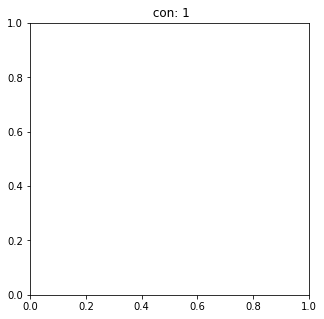

In [13]:
TensorCon(1).show()

## Utils

In [14]:
# export
from typing import List
def same_size_ts(ts:pd.Series, ts_names:List[str]):    
    all_same = [[(ts[c].shape == ts[a].shape) for c in ts_names] for a in ts_names]
    mask = np.array(all_same)    
    return np.sum(mask) == len(ts_names)**2
    

In [15]:
df = pd.DataFrame(data={'ts_0':[pd.Series(np.arange(10)),
                           pd.Series(np.arange(10))],
                   'ts_1':[pd.Series(np.arange(1,11)),
                           pd.Series(np.arange(1,12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
for i, row in df.iterrows():
    if i == 0:
        test_eq(same_size_ts(row,['ts_0','ts_1']),True)
    if i == 1:
        test_eq(same_size_ts(row,['ts_0','ts_1']),False)

In [16]:
# export
def get_part_of_ts(x, lookback_id, length, pad=np.mean):
    if len(x.shape) == 1:
        x = x[None,:]
    if isinstance(x[0,0],int):
        x = x.astype(float)
    if x.shape[-1] < length:
        # If the time series is too short, we pad
        padding = pad(x, -1)
        x = tensor(np.pad(
            x, # report issue https://github.com/numpy/numpy/issues/15606
            pad_width=((0, 0), (length - x.shape[-1], 0)),
            mode='constant',
            constant_values=padding
        )).float()
        assert x.shape == (x.shape[0],length), f"{x.shape}\t,{lookback_id}, 'tsshape':{x.shape}"
    else:
        x = tensor(x[:,lookback_id:lookback_id + length]).float()
    return x


In [17]:
x = np.arange(10)
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
x = np.arange(10)[None,:]
test_eq(get_part_of_ts(x, 2, 5), torch.arange(2,7.)[None,:])
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))
x = np.vstack([np.arange(10)]*2)
test_eq(get_part_of_ts(x, 2, 5), torch.cat([torch.arange(2,7.)[None,:]]*2))
test_eq(get_part_of_ts(x, 0, 11), tensor([[4., 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                          [4, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# report issue https://github.com/numpy/numpy/issues/15606
x = np.arange(10)[None,:]
# test_eq(get_part_of_ts(x, 0, 11), tensor([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# Dataloader

In [159]:
# export
@delegates()
class DfDataLoader(TfmdDL):
    def __init__(self, dataset:pd.DataFrame, y_name, horizon, lookback=72, step=1, min_seq_len=None, max_std= 2, norm=True, **kwargs):
        store_attr(self,'horizon,lookback,step,max_std,norm,y_name')
        self.min_seq_len = ifnone(min_seq_len, lookback)
        self.dataset = dataset
        self.con_names, self.cat_names, self.ts_names = L(), L(), L()
        for col in dataset.columns:
            t = type(dataset[col].iloc[0])
            if t is pd.core.series.Series:
                self.ts_names.append(col)
            elif t is np.ndarray:
                self.dataset[col] = pd.Series([pd.Series(o.flatten()) for o in self.dataset[col]])
                self.ts_names.append(col)
            elif isinstance(dataset[col].iloc[0], int) or t is np.int64:
                self.con_names.append(col)
            elif isinstance(dataset[col].iloc[0], float):
                self.cat_names.append(col)
            else:
                raise Exception(t) 
        assert y_name in self.ts_names
        self.ts_names.remove(y_name)
        n = self.make_ids()
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.skipped= []
        self.ms = {}        

    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        res = super().new(dataset, cls, horizon=self.horizon, lookback=self.lookback, step=self.step , **kwargs)
        res.make_ids()
        return res

    def make_ids(self):
        """Make ids if the sequence is shorter than `min_seq_len`, it will drop that sequence."""
        # Slice each time series into examples, assigning IDs to each
        last_id = 0
        n_dropped = 0
        n_needs_padding = 0
        self._ids = {}
        for i, ts in self.dataset.iterrows(): 
            assert same_size_ts(ts, self.ts_names), f"row {i} are not all the time series the same length"
            num_examples = (ts[self.y_name].shape[-1] - self.lookback - self.horizon + self.step) // self.step
            # Time series shorter than the forecast horizon need to be dropped.
            if ts[self.y_name].shape[-1] < self.min_seq_len:
                n_dropped += 1
                continue
            # For short time series zero pad the input
            if ts[self.y_name].shape[-1] < self.lookback + self.horizon:
                n_needs_padding += 1
                num_examples = 1
            for j in range(num_examples):
                self._ids[last_id + j] = (i, j * self.step)
            last_id += num_examples

        # Inform user about time series that were too short
        if n_dropped > 0:
            print("Dropped {}/{} time series due to length.".format(
                    n_dropped, len(self.dataset)))

        # Inform user about time series that were short
        if n_needs_padding > 0:
            print("Need to pad {}/{} time series due to length.".format(
                    n_needs_padding, len(self.dataset)))
        # Store the number of training examples
        return int(self._ids.__len__() )
    
        def shuffle_fn(self, idxs):
#         self.dataset.shuffle()        
            return idxs

    def get_id(self, idx):
        ts_id, lookback_id = self._ids[idx]
        row = self.dataset.iloc[ts_id, :]
        x = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback)        
        y = get_part_of_ts(row[self.y_name].values, lookback_id, self.lookback + self.horizon)
        tsx = np.concatenate([o[None,:] for o in row[self.ts_names].to_numpy()])
        tsx = get_part_of_ts(tsx, lookback_id, self.lookback + self.horizon)
        r = [TensorSeqs(x, label=[self.y_name + '_x'], m=['g']), 
             TensorSeqs(tsx,label=self.ts_names)]
        if len(self.cat_names):
            r.append(TensorCon(row[self.cat_names].to_numpy().astype(float),label=self.cat_names))
        if len(self.con_names):
            r.append(TensorCon(row[self.con_names].to_numpy().astype(int),label=self.con_names))
        r.append(TensorSeqs(y, label=[self.y_name+ '_y'], m=['r']))
        return Tuple(r)

    def create_item(self, idx):
        if idx>=self.n:
            raise IndexError
        r  = self.get_id(idx)
        if (r[-1]/(r[0].std()+1e-7)).std() > self.max_std:
            if idx not in self.skipped:
#                 print(f"idx: {idx};y.std to high: {(y/x.std()).std()} > {self.max_std}")
                self.skipped.append(idx)
            raise SkipItemException()
              
        return r
    

The data will be stored in pandas DataFrames. This can be use for time series by nesting series into a cell. An example is shown below: 

In [160]:
df = pd.DataFrame(data={'pred':[np.arange(10.),
                           np.arange(12.)],
                   'ts_0':[np.ones(10)[None,:],
                           np.ones(12)[None,:]],
                   'ts_1':[pd.Series(np.arange(1,11)+np.random.randn(10)),
                           pd.Series(np.arange(1,13)+np.random.randn(12))],
                   'var_0':[0.,1.],
                   'con_0':[0,1]})
df

,pred,ts_0,ts_1,var_0,con_0
0,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 1.905018 1 1.968467 2 3.916597 3 3.841399 4 3.829508 5 5.759848 6 7.430524 7 8.618559 8 10.051838 9 11.696105 dtype: float64,0.0,0
1,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]",0 -1.767699 1 1.774293 2 0.914918 3 3.280086 4 5.265459 5 6.725963 6 8.906274 7 9.663796 8 9.936410 9 11.009155 10 10.345346 11 14.799685 dtype: float64,1.0,1


In [161]:
horizon,lookback = 2,9
dl = DfDataLoader(df, 'pred', horizon = horizon, lookback = lookback)


Need to pad 1/2 time series due to length.


In [162]:
for o in dl:
    dct = {k:v for k,v in zip(['x','tsx','cat','con','y'],o)}
    print({k:v.shape for k,v in dct.items()})
    test_eq(dct['x'].shape,(3,1,9))
    break
dl.ts_names

{'x': torch.Size([3, 1, 9]), 'tsx': torch.Size([3, 2, 11]), 'cat': torch.Size([3, 1]), 'con': torch.Size([3, 1]), 'y': torch.Size([3, 1, 11])}


(#2) ['ts_0','ts_1']

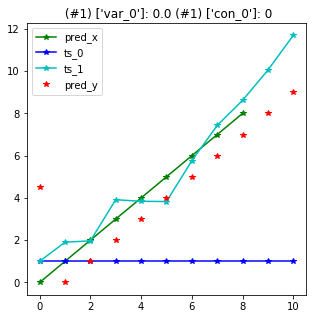

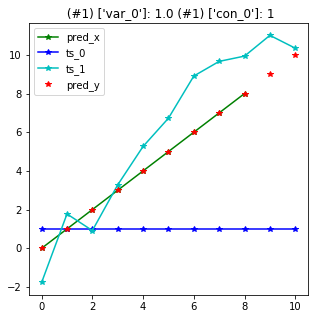

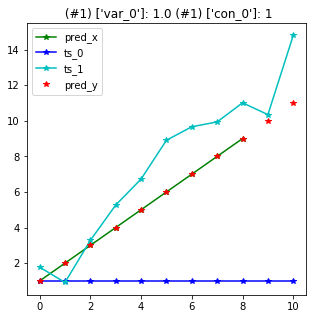

In [163]:
dl.show_batch(max_n=3)

In [182]:
# hide
# without cat or con
horizon,lookback = 2,9
dl = DfDataLoader(df[['x','weather']], 'x', horizon = horizon, lookback = lookback)


for o in dl:
    dct = {k:v for k,v in zip(['x','weather','y'],o)}
    print({k:v.shape for k,v in dct.items()})
    test_eq(dct['weather'].shape, dct['y'].shape)
    test_eq(dct['x'].shape,(64,1,9))
    break


{'x': torch.Size([64, 1, 9]), 'weather': torch.Size([64, 1, 11]), 'y': torch.Size([64, 1, 11])}


# Intergration Example

In [183]:
from fastseq.data.external import *

In [184]:
horizon,lookback = 5,10
df = dummy_data_generator_multi(32)
df.head()

,x,weather,city,cont
0,"[[0.38792473084650436, 0.39572472651523005, 0.07411731812512493, -0.0017652922318472301, -0.3402249478720417, -0.23684497014360092, -0.18196449698698436, -0.06068425635281373, 0.5608682019387887, 0.9817556421753496, 1.1240918949100287, 1.4105052419316806, 1.5364472756986762, 1.551465712026039, 1.073322425307501, 0.7412552876207172, 0.2623780176868972, -0.5527376485065424, -1.4977853651012702, -1.6261592200570194, -1.796307578346697, -2.0222577177031997, -1.759888847722465, -1.394863538109282, -0.9752567079059039, -0.5507208353899998, 0.13997678648937661, 0.4674123752799265, 0.7566351901377...","[[12.333863152002603, 11.959308946916956, 11.46097166855704, 10.966345162198953, 10.609761888138678, 10.493565243144063, 10.657013652613688, 11.062915414937583, 11.606475553741637, 12.143769996143282, 12.531033650621353, 12.662656946558096, 12.496512872217961, 12.059677222371054, 11.43418059392765, 10.728855393081664, 10.047428427601655, 9.463438073807877, 9.009318375680257, 8.681378288822495, 8.456511702999844, 8.312447002998361, 8.24259917608697, 8.259306675507254, 8.384319229654984, 8.630882008535242, 8.98552689941163, 9.398263857482513, 9.786980963107855, 10.056526936937273, 10.1271184...",0,-1.858295
1,"[[0.8664709657513344, 0.4905649336536264, 0.39345969133949527, 0.6614612093387792, 1.1342762551530037, 1.4553065208017222, 1.702415798589702, 1.6101588711621684, 1.5341748027093103, 1.0479537162649823, 0.29346212695138907, -0.234587297431986, -0.9152983133637989, -1.138604543547931, -0.7992259745056586, -0.2528214256142322, 0.17917452419626062, 0.8299128697699284, 0.7678379356078954, 0.8637774222231489, 0.6546044108579039, -0.1732136050546576, -0.766609461565876, -1.0750278114888703, -1.4551238769250214, -1.24389341360968, -1.2533504354436984, -1.0058374939649433, -0.7024171744540748, -0.9...","[[7.3368996455904645, 6.868391421050357, 6.619658176986588, 6.68870965033614, 7.047536035497831, 7.550594296629102, 7.985986090890874, 8.151022142385873, 7.925101461313204, 7.3137711375872065, 6.4481385760849665, 5.539789525832415, 4.807294115635265, 4.400550140251934, 4.349974169684526, 4.558634335220103, 4.840020670101875, 4.98778959634304, 4.852362894081643, 4.396814795549965, 3.711920358373246, 2.9848965187756473, 2.4329888532259005, 2.225682791964142, 2.4234208740573164, 2.954815826823591, 3.6405738167233492, 4.255620283412906, 4.6072457806277045, 4.601362519622789, 4.2732360654511705...",0,1.197658
2,"[[-1.2829054939849227, -1.089051018368898, -1.2137500349026957, -0.8678769075986306, -0.6126188205896562, -0.3608609928010771, 0.19300285619140123, 0.4788927244565521, -0.22572049279797662, -0.3505061484797455, -0.9900340914638074, -1.4667397804787163, -1.6605710124136537, -1.8227298490866781, -1.3689285065519359, -0.4769108023585641, 0.12237156507876311, 0.808279748331978, 1.5092702505688174, 1.3822042356313675, 1.2565285262805714, 0.7638532078321165, 0.6489188720073156, 0.06347254891521156, 0.3562731988051951, 0.06246244493350114, 0.462759330194679, 0.5930386492073102, 1.1028532780300697...","[[5.560994616988789, 5.491000917053083, 5.3957789732544175, 5.272911065424287, 5.119194030731893, 4.931721184839777, 4.709108757862793, 4.4526371366303845, 4.167084395475062, 3.861074392048662, 3.546837050066684, 3.239372271661942, 2.9551060708608894, 2.7102122303521288, 2.518831227353845, 2.3914407050211643, 2.333614490891768, 2.345352584965651, 2.4210811597051367, 2.550322571955118, 2.7189363444973815, 2.910748694643326, 3.1093336083665153, 3.2996911835341183, 3.469591496430658, 3.6104106894042576, 3.7173706881224464, 3.789191105755785, 3.8272557121893906, 3.834471191760718, 3.8140407073...",0,-0.332208
3,"[[1.2963517359001235, 1.0684596155497983, 0.8287609700804536, 0.35673022720060177, 0.5081156330615909, 0.6205429228624927, 0.6837698691024582, 1.0265830704497056, 1.109523911273357, 1.6762658087288476, 1.2598772725668925, 1.1450035809851473, 0.7582686858644989, 0.06243982087811222, -0.19000755681176576, -0.812299422283588

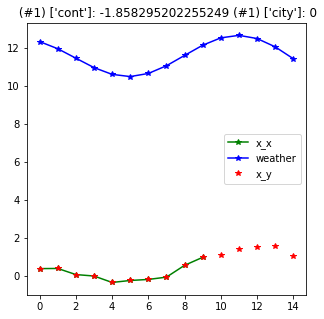

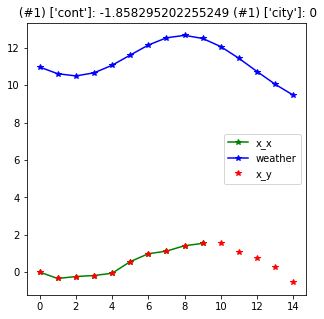

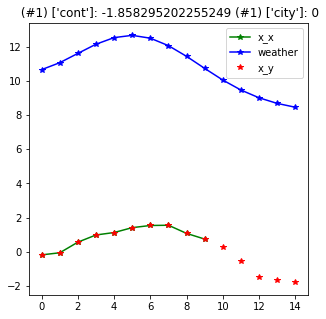

In [185]:
dl = DfDataLoader(df, 'x', horizon = horizon, lookback = lookback, step=3)
dl.show_batch(max_n=3)

In [ ]:
# hide
from nbdev.export import *

notebook2script()